In [1]:
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl > /dev/null 2>&1

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import datatable as dt
import lightgbm as lgb
from matplotlib import pyplot as plt
import riiideducation

_ = np.seterr(divide='ignore', invalid='ignore')

# Preprocess

In [3]:
data_types_dict = {
    'user_id': 'int32', 
    'content_id': 'int16', 
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'

In [4]:
%%time
path = "../input/cleaning-users-features-engineering/reduced_riiid_train.pkl.gzip"
train_df = pd.read_pickle(path)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21973260 entries, 0 to 21973259
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 int8   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  boolean
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(2), int8(3)
memory usage: 859.2 MB
CPU times: user 434 ms, sys: 1.89 s, total: 2.33 s
Wall time: 3.18 s


In [5]:
# train_df = dt.fread('../input/riiid-test-answer-prediction/train.csv', columns=set(data_types_dict.keys())).to_pandas()
train_df = train_df[train_df[target] != -1].reset_index(drop=True)
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df = train_df.astype(data_types_dict)

In [6]:
train_df['lag'] = train_df.groupby('user_id')[target].shift()
cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
train_df['user_correctness'] = cum['cumsum'] / cum['cumcount']
train_df.drop(columns=['lag'], inplace=True)

In [7]:
user_agg = train_df.groupby('user_id')[target].agg(['sum', 'count'])
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count'])

In [8]:
train_df = train_df.groupby('user_id').tail(24).reset_index(drop=True)

In [9]:
questions_df = pd.read_csv(
    '../input/riiid-test-answer-prediction/questions.csv', 
    usecols=[0, 3],
    dtype={'question_id': 'int16', 'part': 'int8'}
)
train_df = pd.merge(train_df, questions_df, left_on='content_id', right_on='question_id', how='left')
train_df.drop(columns=['question_id'], inplace=True)

In [10]:
train_df['content_count'] = train_df['content_id'].map(content_agg['count']).astype('int32')
train_df['content_id'] = train_df['content_id'].map(content_agg['sum'] / content_agg['count'])

In [11]:
valid_df = train_df.groupby('user_id').tail(6)
train_df.drop(valid_df.index, inplace=True)

In [12]:
train_df.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_correctness,part,content_count
0,22,534187,115,0.675307,0,22,2,0,19000.0,False,0.727273,1,12230
1,23,557677,115,0.592028,0,23,3,0,21000.0,False,0.695652,1,17185
2,24,575289,115,0.567251,0,24,3,1,22000.0,False,0.666667,1,14022
3,25,597863,115,0.429466,0,25,3,1,16000.0,False,0.680000,1,58582
4,26,621464,115,0.447794,0,26,2,1,20000.0,False,0.692308,1,20199


# Train

In [13]:
features = [
    'content_id',
    'prior_question_elapsed_time',
    'prior_question_had_explanation',
    'user_correctness',
    'part',
    'content_count'
]

params = {
    'objective': 'binary',
    'seed': 42,
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_bin': 800,
    'num_leaves': 80
}

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.738727	valid_1's auc: 0.726156
[100]	training's auc: 0.740157	valid_1's auc: 0.727146
[150]	training's auc: 0.740853	valid_1's auc: 0.727384
[200]	training's auc: 0.741271	valid_1's auc: 0.727434
[250]	training's auc: 0.741654	valid_1's auc: 0.727469
[300]	training's auc: 0.74206	valid_1's auc: 0.727505
[350]	training's auc: 0.742415	valid_1's auc: 0.72753
[400]	training's auc: 0.742807	valid_1's auc: 0.727544
[450]	training's auc: 0.743185	valid_1's auc: 0.727559
[500]	training's auc: 0.743538	valid_1's auc: 0.727558
Early stopping, best iteration is:
[472]	training's auc: 0.743342	valid_1's auc: 0.727567


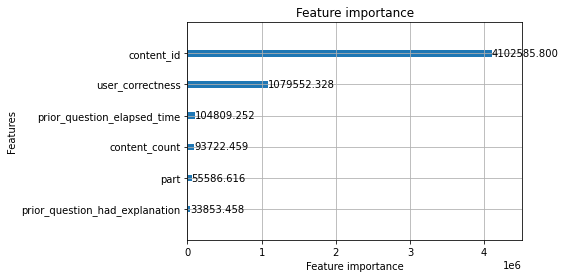

In [14]:
tr_data = lgb.Dataset(train_df[features], label=train_df[target])
va_data = lgb.Dataset(valid_df[features], label=valid_df[target])

model = lgb.train(
    params, 
    tr_data, 
    num_boost_round=10000,
    valid_sets=[tr_data, va_data], 
    early_stopping_rounds=50,
    verbose_eval=50
)

# model.save_model(f'model.txt')
lgb.plot_importance(model, importance_type='gain')
plt.show()

# Inference

In [15]:
user_sum_dict = user_agg['sum'].astype('int16').to_dict(defaultdict(int))
user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
content_sum_dict = content_agg['sum'].astype('int32').to_dict(defaultdict(int))
content_count_dict = content_agg['count'].astype('int32').to_dict(defaultdict(int))

In [16]:
# model = lgb.Booster(model_file='../input/riiid-lgbm-starter/model.txt')
env = riiideducation.make_env()
iter_test = env.iter_test()
prior_test_df = None

In [17]:
%%time

for (test_df, sample_prediction_df) in iter_test:
    if prior_test_df is not None:
        prior_test_df[target] = eval(test_df['prior_group_answers_correct'].iloc[0])
        prior_test_df = prior_test_df[prior_test_df[target] != -1].reset_index(drop=True)
        
        user_ids = prior_test_df['user_id'].values
        content_ids = prior_test_df['content_id'].values
        targets = prior_test_df[target].values
        
        for user_id, content_id, answered_correctly in zip(user_ids, content_ids, targets):
            user_sum_dict[user_id] += answered_correctly
            user_count_dict[user_id] += 1
            content_sum_dict[content_id] += answered_correctly
            content_count_dict[content_id] += 1

    prior_test_df = test_df.copy()
    
    test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop=True)
    test_df = pd.merge(test_df, questions_df, left_on='content_id', right_on='question_id', how='left')
    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(False).astype('bool')    
    
    user_sum = np.zeros(len(test_df), dtype=np.int16)
    user_count = np.zeros(len(test_df), dtype=np.int16)
    content_sum = np.zeros(len(test_df), dtype=np.int32)
    content_count = np.zeros(len(test_df), dtype=np.int32)
    
    for i, (user_id, content_id) in enumerate(zip(test_df['user_id'].values, test_df['content_id'].values)):
        user_sum[i] = user_sum_dict[user_id]
        user_count[i] = user_count_dict[user_id]
        content_sum[i] = content_sum_dict[content_id]
        content_count[i] = content_count_dict[content_id]

    test_df['user_correctness'] = user_sum / user_count
    test_df['content_count'] = content_count
    test_df['content_id'] = content_sum / content_count
       
    test_df[target] = model.predict(test_df[features])
    env.predict(test_df[['row_id', target]])

CPU times: user 313 ms, sys: 6.06 ms, total: 319 ms
Wall time: 101 ms
